- 가장 일반적인 지도 학습 작업: 회귀(값 예측), 분류(클래스 예측)
# MNIST
- 손글씨 숫자 이미지 MNIST(레이블 되어 있음)
- 사이킷런에서 제공하는 여러 헬퍼함수를 통해 유명한 데이터셋을 내려받을 수 있음(\$HOME/scikit_learn_data 디렉터리에 캐싱)

In [2]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1, as_frame=False, parser="auto")
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

> fetch_openml의 parser 매개변수: auto, pandas, liac-arff
- 사이킷런에서 읽어들인 데이터셋들의 기본적인 딕셔너리 구조
  - DESCR: 데이터셋을 설명
  - data: 샘플이 하나의 행, 특성이 하나의 열로 구성된 배열
  - target: 레이블 배열

In [3]:
X, y = mnist["data"], mnist["target"]
print(X.shape, y.shape) #28x28 픽셀 이미지 -> 784개의 특성 존재

(70000, 784) (70000,)


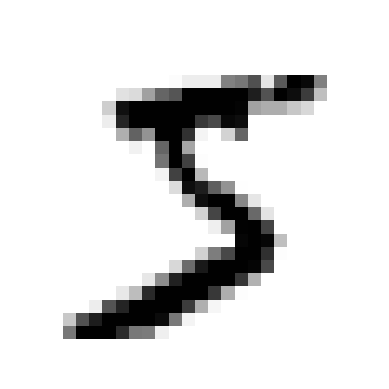

In [4]:
#데이터셋에서 이미지 하나를 확인 -> 샘플의 특성 벡터 추출, 이미지 사이즈로 크기 바꾸기, 맷플롯립의 imshow()함수 사용
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap="binary")
plt.axis("off")
plt.show()

In [5]:
#레이블 데이터셋에서 이미지 하나의 레이블을 확인
y[0]

'5'

In [6]:
#레이블의 데이터값을 변환(문자열->int)
import numpy as np
y = y.astype(np.uint8)

In [7]:
#데이터를 자세히 조사하기 전에 테스트 세트를 만들고 떼어놓기 -> MNIST는 숫자로 구분
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

- 훈련 세트의 순서를 랜덤하게 섞어놓기 -> 모든 교차 검증 폴드를 비슷하게 만듦
  - 예외: 시계열 데이터
  - 예시: SGD

# 이진 분류기(binary classifier) 훈련

In [8]:
#분류 작업을 위한 타깃 벡터 만들기
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

- 확률적 경사 하강법(Stochastic Gradient Descent) 분류기
  - 사이킷런의 SGDClassifier
  - 매우 큰 데이터셋을 효율적으로 처리하는 장점(한번에 하나씩 훈련 샘플을 독립적으로 처리->온라인 학습)

In [9]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [10]:
sgd_clf.predict([some_digit])

array([ True])

# 성능 측정
## 1. 교차 검증을 사용한 정확도 측정
> 교차 검증 구현: 사이킷런이 제공하는 기능보다 더 많이 제어해야할 필요가 있을 떄 직접 구현
> - cross_val_score()와 비슷한 작업 수행, 동일한 결과 출력

In [11]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

#StratifiedKFold는 클래스별 비율이 유지되도록 폴드를 만들기 위해 계층적 샘플링을 수행
skfolds = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)

#매 반복에서 분류기 객체를 복제하여 훈련 폴드로 훈련, 테스트 폴드로 예측을 만듦, 그 후 정확한 예측의 비율 출력
for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.9669
0.91625
0.96785


In [12]:
#cross_val_score() 함수로 폴드가 3개인 k겹 교차 검증을 사용해 SGDClassifier 모델을 평가
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

In [13]:
#모든 이미지를 '5 아님' 클래스로 분류하는 더미 분류기의 정확도
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        return self
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

- 정확도를 분류기의 성능 측정 지표로 선호하지 않는 이유: 불균형한 데이터셋(어떤 클래스가 다른 것보다 월등히 많은 경우)

## 2. 오차 행렬
- 분류기의 성능을 평가하는 더 좋은 방법 (잘못 분류된 횟수를 세는 것이 기본 아이디어)
- 실제 타겟과 비교할 수 있는 예측값을 만들기
  - 테스트 세트를 여기서 사용하면 안됨. 
  - cross_val_predict() 함수를 사용: k겹 교차 검증을 수행하지만 평가 점수를 반환하지 않고 각 테스트 폴드에서 얻은 예측을 반환
    - 훈련 세트의 모든 샘플에 대해 깨끗한 예측(모델이 훈련하는 동안 보지 못했던 데이터에 대해 예측)

In [14]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)
confusion_matrix(y_train_5, y_train_pred) #타깃 클래스, 예측한 클래스

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

실제 클래스\예측한 클래스|negative|positive
---|---|---
negative|true negative|false positive
positive|false negative|true positive

In [15]:
#완벽한 분류기일 경우 -> 오차 행렬의 주대각선만 0이 아닌 값이 됨
y_train_perfect_predictions = y_train_5
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]], dtype=int64)

- $정밀도 = \frac{TP}{TP+FP}$ (양성 예측의 정확도)
- $재현율 = \frac{TP}{TP+FN}$ (민감도, 진짜 양성 비율 true positive rate)

## 3. 정밀도와 재현율
- 사이킷런은 정밀도, 재현율 등 분류기의 지표를 계산하는 함수 제공

In [16]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [17]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

- F1 점수: 정밀도와 재현율의 조화 평균 
  - $F_1 = \frac{2}{\frac{1}{정밀도}+\frac{1}{재현율}} = 2 \times \frac{정밀도 \times 재현율}{정밀도 + 재현율} = \frac{TP}{TP+\frac{FN+FP}{2}}$

In [18]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343846

![f_score](./f_score.png)

- 정밀도와 재현율이 비슷한 분류기에서는 F1점수가 높음
  - 상황에 따라서 낮은 재현율을 가지는 대신 높은 정밀도가 필요한 경우(가짜 음성이 높아도 가짜 양성이 낮아야하는 경우)
  - 혹은 낮은 정밀도를 가지는 대신 높은 재현율이 필요한 경우(가짜 양성이 높아도 가짜 음성이 낮아야하는 경우)

## 4. 정밀도/재현율 트레이드오프
- 정밀도를 올리면 재현율이 줄고, 재현율을 올리면 정밀도가 줄음.
- SGDClassifier가 결정함수를 통해 분류를 결정(임곗값보다 크면 양성, 작으면 음성)
![trade_off](./precision_recall_trade_off.png)
- 사이킷런에서 임곗값을 직접 지정할 순 없음; 예측에 사용한 점수 확인 가능(decision_function() 메서드 호출)

In [19]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [20]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred #predict() 메서드 내부에서 일어나는 일

array([ True])

In [21]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

- 임계값을 높이고 재현율이 낮아짐(가짜음성이 많아지므로)
- 적절한 임곗값을 정하는 방법
  1. cross_val_predict() 함수 사용, 결정 점수를 반환받도록 지정
  2. precision_recall_curve() 함수 사용 -> 가능한 모든 임곗값에 대해 정밀도, 재현율 계산 가능

In [22]:
from sklearn.metrics import precision_recall_curve

y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:,-1], "b--", label="정밀도")
    plt.plot(thresholds, recalls[:-1], "g-", label="재현율")